# Keypoint matching feasibility study

Although most recent papers on the BelgaLogos dataset use convolutional neural networks, there are a few papers available discussing keypoint matching.
 - [Chu, Lin 2012](https://www.cs.ccu.edu.tw/~wtchu/papers/2012ICASSP2-chu2.pdf) 
 - [Roy, Garain 2012](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.713.9134&rep=rep1&type=pdf)

In keypoint matching, the first step is to generate a set of keypoints that characterise the feature that you
want to match in a target image (i.e a brand logo). These keypoints should be acommpanied by a set of 'descriptors' (i.e local image orientation) that are as close to invariant under affine transformations as possible. In this way, matching between a template image and rotated/scaled/skewed versions of the image should be possible. There are a few algorithms available for generating keypoints:

1. [ORB](https://en.wikipedia.org/wiki/Oriented_FAST_and_rotated_BRIEF)
2. [SIFT](https://en.wikipedia.org/wiki/Scale-invariant_feature_transform) (*patented*)
3. [SURF](https://en.wikipedia.org/wiki/Speeded_up_robust_features) (*patented*)

Here we will examine which are most effective (bearing in mind that for commercial purposes SIFT and SURF are not free to use). Once keypoints are generated in both the test and target images, a match between them is attempted. 
 

#### Setup - utility functions

In [1]:
import cv2
from random import randint
from matplotlib import pyplot as plt

# Helper Function to plot a list of images side-by-side
def plot_image_list(images, titles, figsize):
    nimages = len(images)    
    fig, ax = plt.subplots(1, nimages, figsize=figsize)
    for i in range(nimages):
        ax[i].imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        ax[i].set_title(titles[i])
    plt.show()
    
# Helper function to generate random colours for annotations
def get_random_colour():
    """ 
        This returns a random BGR colour tuple, constructed
        so as to avoid colours close to black (0,0,0) or white
        (255, 255, 255). This is to increase contrast on
        greyscale images.
    """        
    random_b = randint(0, 255)
    random_g = randint(0, 255)
    random_r = 255 - (random_b + random_g)/2
    return (random_b, random_g, random_r) 

#### KIA test case
Let's take an example logo (KIA) and image from the BelgaLogos dataset, and study the keypoints generated by the various keypoint finding algorithms. Firstly we'll set up the different finders and write a quick analysis function to plot images and their keypoints:

In [2]:
import keypoint_matching as kp

keypoint_finders = { "ORB":  cv2.ORB_create(10000),
                     "SIFT": cv2.xfeatures2d.SIFT_create(),
                     "SURF": cv2.xfeatures2d.SURF_create()}

def keypoint_distribution_analysis(logo, test):
    """ For a provided pair of OpenCV images, draw a keypoint distribution plot for each keypoint finder"""
    for name, finder in keypoint_finders.items():
        logo_keypoints, logo_nkps = kp.find_and_plot_keypoints(logo, finder)
        test_keypoints, test_nkps = kp.find_and_plot_keypoints(test, finder)
        # Plot the keypoint-annotated images for this finder
        plot_image_list([logo_keypoints, test_keypoints], ["Template", "Test"], figsize = (15,10))
        # Print information on the number of keypoints
        print("Finder: ", name)
        print("Number of keypoints in logo image: ", logo_nkps)
        print("Number of keypoints in test image: ", test_nkps)

Secondly, let's load the example images
- `kia_logo_image` : A high-quality version of the KIA logo, taken from the 'Illustrations' on the BelgaLogos webpage.
- `kia_test_image`: An image from the BelgaLogos set containing several instances of the KIA logo

and run the analysis function over them:

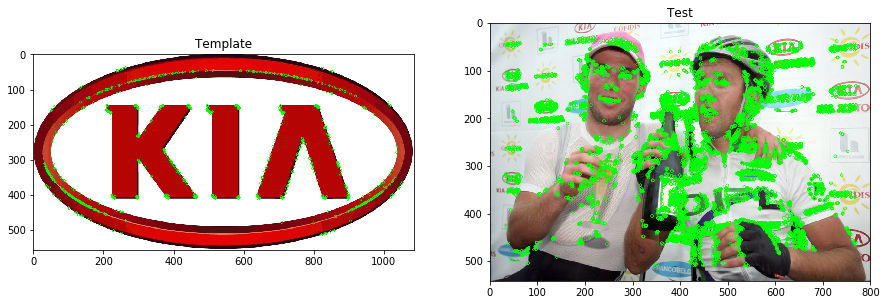

Finder:  ORB
Number of keypoints in logo image:  1008
Number of keypoints in test image:  8448


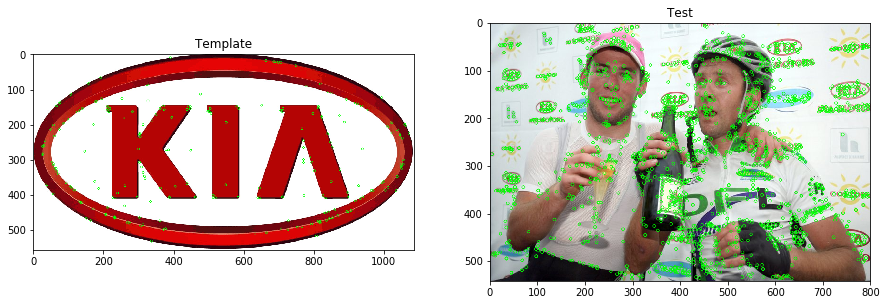

Finder:  SIFT
Number of keypoints in logo image:  277
Number of keypoints in test image:  2317


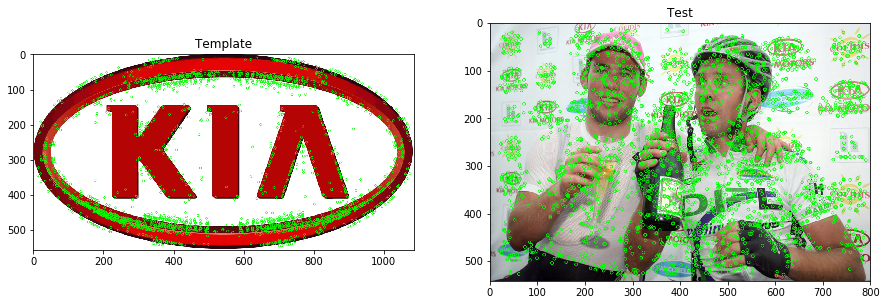

Finder:  SURF
Number of keypoints in logo image:  2255
Number of keypoints in test image:  3152


In [9]:
# Read template image - the KIA logo
kia_logo_filename = "data/logos/kia.jpg"
kia_logo_image = cv2.imread(kia_logo_filename)
    
# Read an example test image
kia_test_filename = "data/images/07596671.jpg"
kia_test_image = cv2.imread(kia_test_filename)

# Perform keypoint distribution analysis
keypoint_distribution_analysis(kia_logo_image, kia_test_image)

The three keypoint finding algorithms clearly find very different ways to characterise the geometry of the images.
- The ORB finder results in by far the most number of keypoints. They are far more clustered than in the other algorithms, and appear to focus on *corners* in the KIA logo. Furthermore there appears to be an 'edge effect' where no points are found near the edge of the image.
- The SIFT finder results in the fewest keypoints, with a very different distribution to ORB. Points are located both along edges and in the interior of coloured logo segments.
- The SURF finder has points distributed in a simmilar way as to SIFT (edges and a few interior points) but many more keypoints are found.

### Keypoint localisation

Now that we have succesfully determined image keypoints, let's move towards matching the logo keypoints to the test image. As there are multiple examples of the KIA logo in the test image, a direct, 'naive' match could result in the original logo keypoints matching to multiple different logos in the target simultaneously. To localise the logo we can either

1. Use a sliding-window, perform keypoint-matching in each window.
2. Cluster the keypoints, performing keypoint-matching for each cluster.

Approach (2) appears to be the most commonly used in keypoint matching, typically with Mean-Shift clustering. Mean-Shift being used as it does not require the user to specify a desired number of clusters. This is naturally crucial as we have no way of knowing how many logo instances are present in a test image.

#### Keypoint clustering test

Let's try and cluster the keypoints generated by the three different keypoint finders according to the Mean-Shift algorithm. If each instance of the logo in the test image is then located in a distinct cluster, then the algorithm is working.

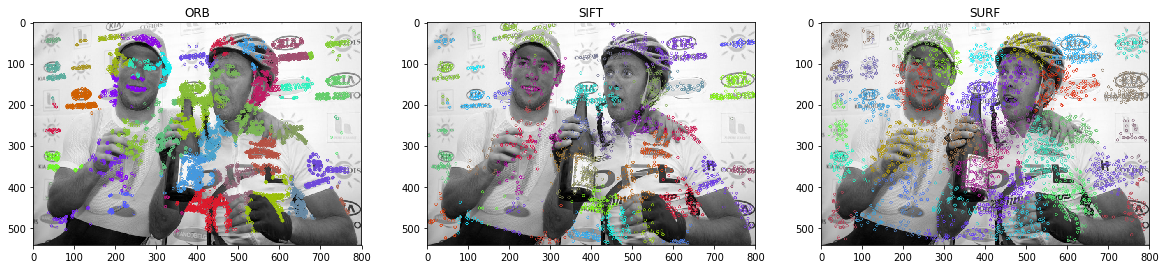

In [4]:
cluster_image_list = []
cluster_titles = [name for name, finder in keypoint_finders.items()]
  
# Loop over finders
for name, finder in keypoint_finders.items():
    # Perform Mean-Shift clustering
    clusters, descriptors = kp.meanshift_keypoint_clusters(kia_test_image, finder)
    
    # Prepare a greyscale 'backdrop' image for clarity
    cluster_image = kia_test_image.copy()
    cluster_image = cv2.cvtColor(cluster_image, cv2.COLOR_RGB2GRAY)
    cluster_image = cv2.cvtColor(cluster_image, cv2.COLOR_GRAY2BGR)
    
    # Render each cluster to the cluster_image with a random colour
    for cluster in clusters:
        cv2.drawKeypoints(cluster_image, cluster, cluster_image, color=get_random_colour())
    
    # Add this finder's cluster image to the list
    cluster_image_list.append(cluster_image)
    
# Plot the cluster images
plot_image_list(cluster_image_list, cluster_titles, figsize=(20,20))

The clustering appears to be doing a good job for all keypoint finders. The individual KIA logos are all in their own clusters, with no aparrent overlap. When writing the `meanshift_keypoint_clusters` function I found there is some sensitivity to the `quantile` parameter of the Mean-Shift bandwidth estimation. This will have to be studied if keypoint matching is to be used as the final classifier.

### Keypoint matching

Now that we have keypoints in feature clusters, we can attempt to match the KIA logo to these clusters. At first we will try the OpenCV brute-force matching.

Keypoint matching proceeds by taking the descriptors associated with two sets of keypoints, and finding pairs which minimise the distance to each other, for a given definition of distance. Here we will use the Hamming distance for the ORB descriptors (they are word-based) and Euclidean (L2) distance for SIFT and SURF.

In [5]:
# ORB uses word-based descriptors, so the HAMMING distance must be used
keypoint_norms   = { "ORB":  cv2.NORM_HAMMING,
                     "SIFT": cv2.NORM_L2SQR, # Use the squared norm to avoid taking an unneccesary sqrt
                     "SURF": cv2.NORM_L2SQR}

In the `keypoint-matching` module I have written a function to perform the brute-force matching of a template image to a (clustered) set of keypoints in a test image. The homography between the template and the matching points is computed, and a set of proposed bounding-boxes are drawn on the test image. Let's try running this function over our three keypoint finders.

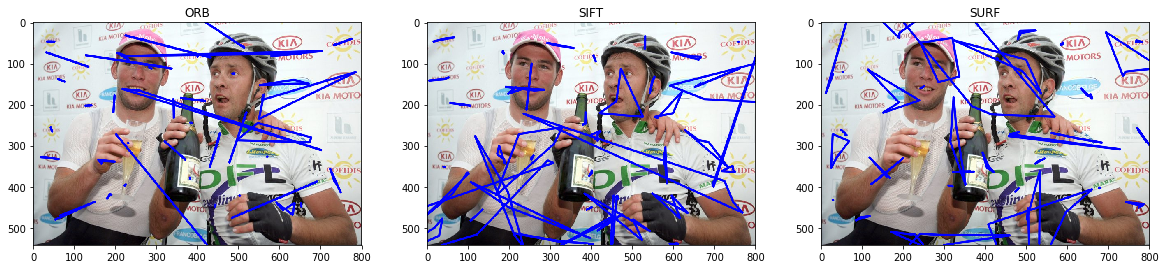

In [6]:
# Loop over finders, generating bounding-box annotated images for each finder
annotated_images = []
for name, finder in keypoint_finders.items():
    img = kp.bruteforce_match_clusters(kia_logo_image, kia_test_image, finder, keypoint_norms[name])
    annotated_images.append(img)
plot_image_list(annotated_images, cluster_titles, figsize=(20,20))

A mixed set of results! While the ORB and SURF keypoints fail to match any points successfully, the SIFT match does quite well, matching 7/8 logos, including a significantly occluded one. However all three have a very high false-positive match rate as there is no quality filter on the matches. 

We can improve this by accepting proposed bounding-boxes only when there is a minimum number (say, 10) of high-quality matches (inliers) as judged by the algorithm that finds the homography transform.

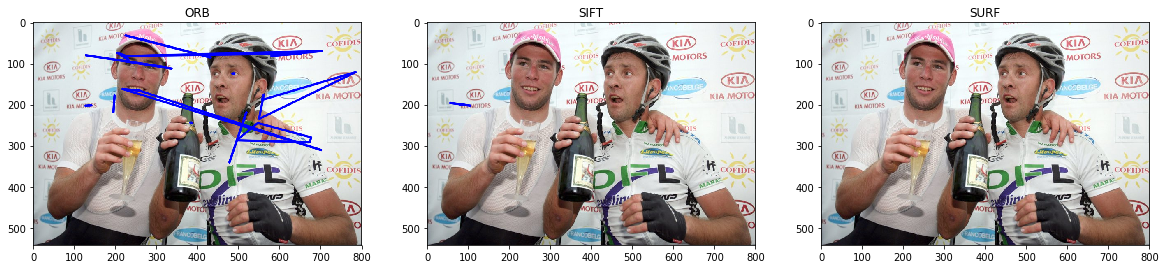

In [7]:
# Generate matched bounding-boxes with a minimum number of inliers
annotated_images_min_inliers = []
for name, finder in keypoint_finders.items():
    img = kp.bruteforce_match_clusters(kia_logo_image, kia_test_image, 
                                       finder, keypoint_norms[name],
                                       MIN_INLIERS=10)
    annotated_images_min_inliers.append(img)
plot_image_list(annotated_images_min_inliers, cluster_titles, figsize=(20,20))

We have now trimmed out almost all of the false-positives (with the exception of a few in the ORB analysis). The SIFT keypoint set is the obvious winner achieving 6 matches out of a possible 8, with no false-positives. With this cut we do lose the one partially occluded match at the bottom-right of the image.

For one last check, we re-perform the matching but with different distance measures. In the above comparison, the L2 norms were used for SIFT and SURF, now we try the L1 norm.

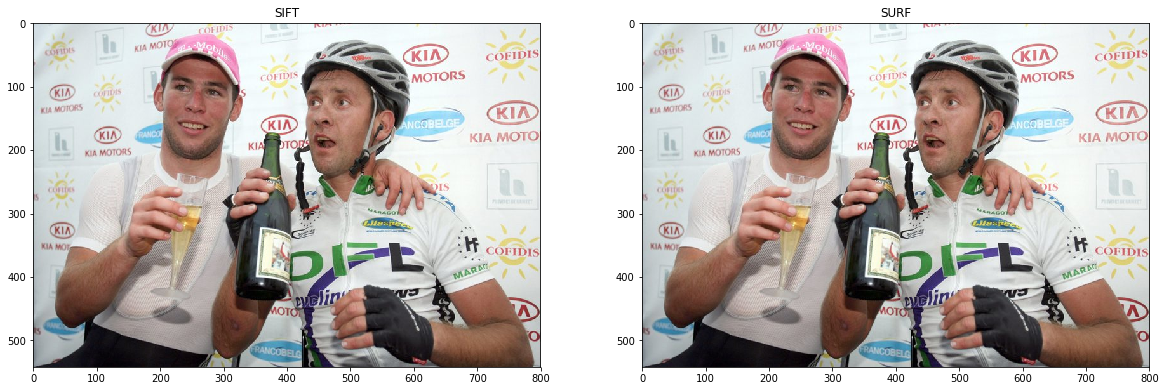

In [8]:
# ORB uses word-based descriptors, so the HAMMING distance must be used
keypoint_norms_2   = { "SIFT": cv2.NORM_L1,
                       "SURF": cv2.NORM_L1}
# Generate matched bounding-boxes with a minimum number of inliers
annotated_images_alternative_norms = []
for name, norm in keypoint_norms_2.items():
    finder = keypoint_finders[name]
    img = kp.bruteforce_match_clusters(kia_logo_image, kia_test_image, 
                                       finder, norm,
                                       MIN_INLIERS=10)
    annotated_images_alternative_norms.append(img)
plot_image_list(annotated_images_alternative_norms, 
                [name for name, x in keypoint_norms_2.items()],
                figsize=(20,20))

No improvement is aparrent in either case, the particular choice of norm between L1 and L2 is likely to be relatively unimportant.

## Conclusions of feasibility study

Although far from perfect, it is clear that logo identification in the BelgaLogos dataset can be achieved through SIFT keypoint matching. The matching can probably be further improved (via k-NN matching rather than brute force for example) but there is already an acceptable match rate for the SIFT keypoint set on the KIA test image.

However, this test case is a particuarly easy case for a number of reasons.

1. The logo in the test image is a good match for the template (they are not brightness-inverse for example).
2. The logos in the test image are of high-quality, on a clear background and with little rotation/scaling.
3. The test logos are relatively large, smaller logos may not generate enough keypoints for a successful match.

So deployment across the whole BelgaLogos dataset will have to be taken with care. There are a few key parameters (bandwidth estimation quartile, number of matched inliers) which can be used to tune the ROC curve when we look at the full dataset.